In [0]:
!pip install q keras==2.3.0
!pip install tensorflow_hub

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt

#%tensorflow_version 1.x
import tensorflow as tf

import tensorflow_hub as hub
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import pickle

import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

In [0]:
pd.set_option("display.precision", 8)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_root='/content/drive/My Drive/Image_Quality_Analysis/data/dataset-1/train'
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory( TRAINING_DATA_DIR, subset="validation",
                                                      shuffle=True, target_size=IMAGE_SHAPE)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR, subset="training",
                                                      shuffle=True, target_size=IMAGE_SHAPE)

Found 902 images belonging to 3 classes.
Found 3617 images belonging to 3 classes.


In [0]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
print(dataset_labels)
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)
[('Blur', 0), ('MacroBlocking', 1), ('Normal', 2)]
['Blur' 'Macroblocking' 'Normal']


In [0]:
le = LabelEncoder()
labels = le.fit_transform(dataset_labels)
#labels = np_utils.to_categorical(labels, 3)
print(labels)
with open('/content/drive/My Drive/Image_Quality_Analysis/model/labelEncoderFile_04082020.pkl', 'wb') as fid:
    pickle.dump(le, fid)

[0 1 2]


In [0]:
with open('/content/drive/My Drive/Image_Quality_Analysis/model/labelEncoderFile_04082020.pkl', 'rb') as fid:
    le_loaded = pickle.load(fid)

print(le_loaded.inverse_transform([1]))

['Macroblocking']


In [0]:
train_generator.class_indices

{'Blur': 0, 'MacroBlocking': 1, 'Normal': 2}

In [0]:
model = tf.keras.Sequential([
                    hub.KerasLayer(
                        "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                        output_shape=[1280], trainable=False
                    ),
                    tf.keras.layers.Dropout(0.4),
                    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
                    ])

model.build([None, 224, 224, 3])
model.summary()

model.compile( optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit_generator( train_generator, epochs=10, verbose=1,
                            steps_per_epoch=steps_per_epoch,
                            validation_data=valid_generator,
                            validation_steps=val_steps_per_epoch
                           ).history

model.save("/content/drive/My Drive/Image_Quality_Analysis/model/ImageQuality_TL_GD_V1_0408.h5")
model.save_weights("/content/drive/My Drive/Image_Quality_Analysis/model/ImageQualityWeights_TL_GD_V1_0408.h5")

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/10
114/114 [==============================] - 2658s 23s/step - loss: 0.2851 - acc: 0.9010 - val_loss: 0.0674 - val_acc: 0.9933
Epoch 2/10
114/114 [==============================] - 218s 2s/step - loss: 0.1082 - acc: 0.9674 - val_loss: 0.0617 - val_acc: 0.9933
Epoch 3/10
114/114 [==============================] - 217s 2s/step - loss: 0.0835 - acc: 0.9721 - val_loss: 0.0282 - val_acc: 0.9933
Epoch 4/10
114/114 [==============================] - 218s 2s/step - loss: 0.0695 - acc: 0.9759 - val_loss: 0.0283 - val_acc: 0.9911
Epoch 5/10
114/114 [==============================] - 217s 2s/step - loss: 0.0593 - acc: 0.9795 - val_loss: 0.0485 - val_acc: 0.9911
Epoch 6/10
114/114 [==============================] - 216s 2s/step - loss: 0.0520 - acc: 0.9829 - val_loss: 0.0370 - val_acc: 0.9922
Epoch 7/10
114/114 [==============================] - 219s 2s/step - loss: 0.0549 - acc: 0.9804 - val_loss: 0.0241 - val_acc: 0.9956
Epoch 8/10
114/114 [==============================] - 216s 2s/step 

In [0]:
from keras import models
#new_model = models.load_model('/content/drive/My Drive/3kImages/models/ImageQualityX1.h5')
model = tf.keras.models.load_model('/content/drive/My Drive/Image_Quality_Analysis/model/ImageQuality_TL_GD_V1_0408.h5',custom_objects={'KerasLayer':hub.KerasLayer})
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Validation batch shape: (32, 224, 224, 3)
Prediction results for the first elements


,Blur,Macroblocking,Normal
0,0.97127366,0.00030356,0.02842270
1,0.98932588,0.00025945,0.01041469
2,0.00305848,0.00090534,0.99603623
3,0.00000041,0.99664295,0.00335669
4,0.00000172,0.99947220,0.00052613


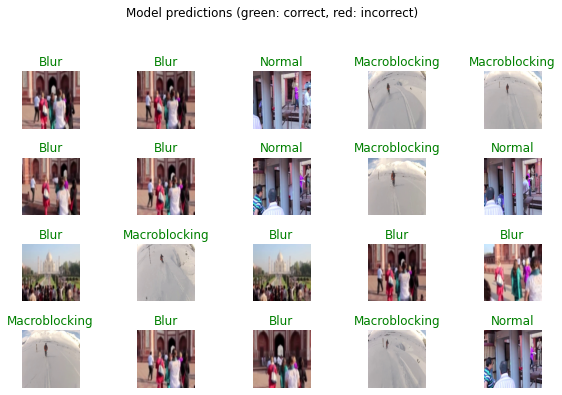

In [0]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [0]:
from keras import models
#new_model = models.load_model('/content/drive/My Drive/3kImages/models/ImageQualityX1.h5')
new_model = tf.keras.models.load_model('/content/drive/My Drive/Image_Quality_Analysis/model/ImageQuality_TL_GD_V1_0408.h5',custom_objects={'KerasLayer':hub.KerasLayer})
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os

# image folder
folder_path = '/content/drive/My Drive/3kImages/miniTest/MacroBlocking'
# path to model
model_path = '/path/to/saved/model.h5'
# dimensions of images
img_width, img_height = 224, 224

actual_labels = []
# load all images into a list
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)
    actual_labels.append(0)
    #print(img)

# stack up images list to pass for prediction
images = np.vstack(images)
classes = new_model.predict_classes(images, batch_size=10)
print(classes)

In [0]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os

# image folder
folder_path = '/content/drive/My Drive/3kImages/test/MacroBlocking'

# dimensions of images
img_width, img_height = 224, 224

# load all images into a list
images = []
img = "/content/drive/My Drive/3kImages/test/MacroBlocking/5072.jpg"
img = image.load_img(img, target_size=(img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
images.append(img)

# stack up images list to pass for prediction
images = np.vstack(images)
classes = new_model.predict_classes(images, batch_size=10)
print(classes)

[0]


In [0]:
test_image = image.load_img('/content/drive/My Drive/Image_Quality_Analysis/data/dataset-1/test/Normal/TAJframe3427.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
test_image = test_image/255

print(test_image.shape)

result = new_model.predict(test_image)
print(result)
#predict_proba = new_model.predict_proba(test_image)
prediction_result = np.argmax(result[0])
print(prediction_result)


(1, 224, 224, 3)
[[0.063403   0.01540267 0.9211943 ]]
2


In [0]:
from keras.preprocessing.image import ImageDataGenerator

data_root='/content/drive/My Drive/Image_Quality_Analysis/data/dataset-1/test'

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(directory=TRAINING_DATA_DIR, target_size = (224, 224),
                                            batch_size = 2278, shuffle=False)

sample_training_images, _ = next(test_set)
print(test_set.labels[800:815])

#plt.figure(figsize=(12, 12))

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 20, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
# plotImages(sample_training_images[800:815])
'''
for i in range(40):
  plt.figure(figsize=(12, 12))
  #plt.imshow(sample_training_images[i+800])
  #plt.show()
'''
total_validate = 44
batch_size = 32


#predict = new_model.predict(test_set, steps=np.ceil(total_validate/32))

print('before running prediction')
predict = new_model.predict(sample_training_images)
print('after running prediction')
predict=np.round(predict,decimals=5)
result = map(lambda v : np.argmax(v), predict)
prediction_result = np.array(list(result))
print(prediction_result[800:815])
#print(predict)

#test_labels = np.array(np.zeros(44))
#print(test_labels.shape)
#my_data = (test_set, test_labels)
#test_loss, test_acc = new_model.evaluate(my_data)
#print(test_acc)


Found 2278 images belonging to 3 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
before running prediction
after running prediction
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [0]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

classification_report = metrics.classification_report(test_set.labels, prediction_result, target_names = test_set.class_indices.keys())
print("Classification report: \n", classification_report)
confusion_matrix = metrics.confusion_matrix(test_set.labels, prediction_result)
print("Confusion matrix: \n",confusion_matrix)

print("Accuracy Score: ", accuracy_score(test_set.labels, prediction_result))
print("F1 Score: ", f1_score(test_set.labels, prediction_result, average='weighted'))
print("Precision Score: ", precision_score(test_set.labels, prediction_result, average='weighted'))
print("Recall Score: ", recall_score(test_set.labels, prediction_result, average='weighted'))

Classification report: 
                precision    recall  f1-score   support

         Blur       0.94      1.00      0.97      1763
MacroBlocking       0.87      1.00      0.93       241
       Normal       0.94      0.47      0.62       274

     accuracy                           0.93      2278
    macro avg       0.92      0.82      0.84      2278
 weighted avg       0.93      0.93      0.92      2278

Confusion matrix: 
 [[1755    0    8]
 [   0  241    0]
 [ 109   37  128]]
Accuracy Score:  0.932396839332748
F1 Score:  0.9223138022623416
Precision Score:  0.9335877652557769
Recall Score:  0.932396839332748


In [0]:
import cv2
from keras.preprocessing import image
vidcap = cv2.VideoCapture('/content/drive/My Drive/3kImages/MAcroBlocking.mp4')
print(cv2.__version__)

success,img = vidcap.read()
count = 0
newsize = (128, 128) 
images = []
while success:
  print(count, ' image : ' , img.size)
  img = cv2.resize(img, newsize, interpolation = cv2.INTER_AREA)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)

  prediction_probability = new_model.predict(img)
  prediction_result = np.argmax(prediction_probability[0])
  images.append(prediction_result)
  # cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file

  success,img = vidcap.read()
  count += 1

print('final result')
print(images)
vidcap.release()
cv2.destroyAllWindows()

In [0]:
import cv2
from keras.preprocessing import image
vidcap = cv2.VideoCapture('/content/drive/My Drive/3kImages/faces_noblur.mp4')
print(cv2.__version__)

success,img = vidcap.read()
count = 0
newsize = (224, 224) 
images = []
while success:
  img = cv2.resize(img, newsize, interpolation = cv2.INTER_AREA)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)

  prediction_probability = new_model.predict(img)
  prediction_result = np.argmax(prediction_probability[0])
  images.append(prediction_result)
  # cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file

  success,img = vidcap.read()
  count += 1

print('final result')
print(images)
vidcap.release()
cv2.destroyAllWindows()

4.1.2
final result
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,